In [151]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import io
import numpy as np
import re

### M1/M2

In [152]:
url='https://cdn.amcm.gov.mo/uploads/attachment/2024-07/1_Money_75.xlsx'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r=requests.get(url, headers=headers)
if r.ok:
    data=r

In [153]:
df=pd.read_excel(io.BytesIO(data.content), sheet_name='M2')
# col=[re.sub(r'\(.*?\)', '', i[0][1]) if (i[1][1]==None) else re.sub(r'\(.*?\)', '', i[1][1]) for i in 
#  zip(enumerate(df.iloc[8].replace(np.nan, None)), enumerate(df.iloc[10].replace(np.nan, None)))]
col=['Year', 'Month', 'M2','M2-MOP',
 'M2-HKD',
 'M2-RMB',
 'M2-USD',
 'M2-Others ',
 'M1',
 'M1-MOP',
 'M1-HKD',
 'M1-RMB',
 'M1-USD',
 'M1-Others ',
 'Quasi-monetary Liab.',
 'Liab.-MOP',
 'Liab.-HKD',
 'Liab.-RMB',
 'Liab.-USD',
 'Liab.-Others ']
df.columns=col
df=df[13:].replace('..', 0)


def fnd_previous(pos, lst):
    return fnd_previous(pos-1, lst) if lst[pos][1] is None else lst[pos][1]

lst = list(enumerate(df['Year'].replace(np.nan, None)))
df['Year'] = [fnd_previous(i, lst) for i, _ in lst]
df=df.dropna()
df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))
df=df.set_index('Date')
df_money=df

C:\Users\tonyfong\AppData\Local\Temp\ipykernel_20468\242949146.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df=df[13:].replace('..', 0)


### Foreign Assets/Monetary Base

In [154]:
url='https://cdn.amcm.gov.mo/uploads/attachment/2024-07/7_Central_Bank_Survey_74.xlsx'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r=requests.get(url, headers=headers)
if r.ok:
    data=r

In [155]:
df=pd.read_excel(io.BytesIO(data.content), sheet_name='AMCM Net Foreign Assets')
col=['Year', 'Month', '', 'Net Foreign Assets', 'Foreign Assets', 'Foreign Exchange Reserves', 'Other Foreign Assets', 'Foreign Liab.']
df.columns=col
df=df[13:].replace('..', 0)


def fnd_previous(pos, lst):
    return fnd_previous(pos-1, lst) if lst[pos][1] is None else lst[pos][1]

lst = list(enumerate(df['Year'].replace(np.nan, None)))
df['Year'] = [fnd_previous(i, lst) for i, _ in lst]
df=df.dropna(axis=1)
df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))
df=df.set_index('Date')
df_foreign_asset=df

In [156]:
df=pd.read_excel(io.BytesIO(data.content), sheet_name='Monetary Base', usecols='A:F')
col=['Year', 'Month', 'Monetary Base', 'Certificate of Indebtedness', 'Coins issued', 'Deposits of Banks with the AMCM']
df.columns=col
df=df[13:].replace('..', 0)


def fnd_previous(pos, lst):
    return fnd_previous(pos-1, lst) if lst[pos][1] is None else lst[pos][1]

lst = list(enumerate(df['Year'].replace(np.nan, None)))
df['Year'] = [fnd_previous(i, lst) for i, _ in lst]
df=df.dropna(subset=['Monetary Base'])
df['Date']=pd.to_datetime(df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1))
df=df.set_index('Date')
df_monetary_base=df

### GDP

In [182]:
url='https://api.data.gov.mo/datadir/downloadSingleFile?fileId=835&dataDirId=08d5d237-ea56-46f4-9336-1597512f9ef9&token=hD27Sbc5USxPEcOxUG4nGHaBpNUojL6f'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r=requests.get(url, headers=headers)
if r.ok:
    data=r

In [252]:
df=pd.read_excel(io.BytesIO(data.content))

df=df[~df['period'].str.contains('季')]
df['Date']=pd.to_datetime(df['period'].str.replace('年', ''))
df['GDP']=df['value'].astype(float)
df=df.set_index('Date')


for yr in df.index.year[:-1]:
    for m in range(2,13):
        df.loc[pd.to_datetime(f'{yr}-{str(m).zfill(2)}-01')]=df.loc[pd.to_datetime(f'{str(yr-1)}-01-01')]

df_GDP=df

### Conso

In [260]:
df=pd.concat([df_foreign_asset, df_monetary_base, df_money, df_GDP], axis=1)

### Chart

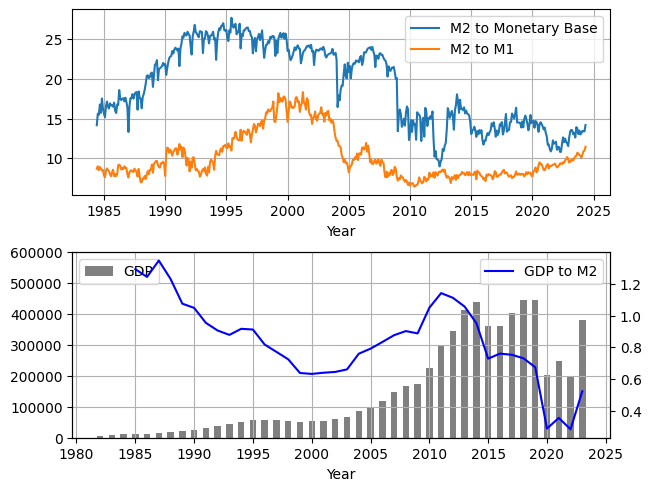

In [306]:
df['m2_monbase']=df['M2']/df['Monetary Base']
df['m2_m1']=df['M2']/df['M1']
df['gdp_m2']=df['GDP']/df['M2']

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(df['m2_monbase'], label='M2 to Monetary Base')
axs[0].plot(df['m2_m1'], label='M2 to M1')
axs[0].set_xlabel('Year')
axs[0].grid(True)
axs[0].legend()

gdp_plt=df.loc[df.index.strftime('%m-%d') == '01-01', 'GDP']
axs[1].bar(df.loc[df.index.strftime('%m-%d') == '01-01'].index, df.loc[df.index.strftime('%m-%d') == '01-01', 'GDP'], 
         label='GDP', color='grey' ,width=200)
axs[1].axis(ymax=600000)
axs[1].set_xlabel('Year')

axs2 = axs[1].twinx()
axs2.plot(df.loc[df.index.strftime('%m-%d') == '01-01']['gdp_m2'], label='GDP to M2', color='blue')


axs[1].grid(True)
axs[1].legend()
axs2.legend()

plt.show()

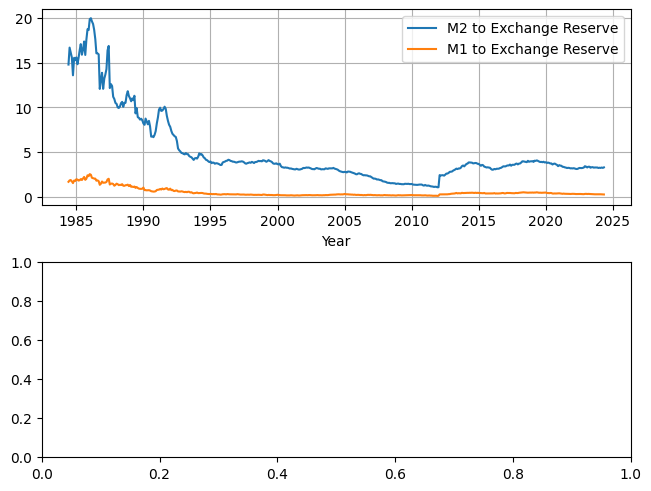

In [302]:
df['m2_reserve']=df['M2']/df['Foreign Exchange Reserves']
df['m1_reserve']=df['M1']/df['Foreign Exchange Reserves']
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(df['m2_reserve'], label='M2 to Exchange Reserve')
axs[0].plot(df['m1_reserve'], label='M1 to Exchange Reserve')
axs[0].set_xlabel('Year')
axs[0].grid(True)
axs[0].legend()

In [181]:
df.columns

Index(['Year', 'Month', 'Net Foreign Assets', 'Foreign Assets',
       'Foreign Exchange Reserves', 'Other Foreign Assets', 'Foreign Liab.',
       'Year', 'Month', 'Monetary Base', 'Certificate of Indebtedness',
       'Coins issued', 'Deposits of Banks with the AMCM', 'Year', 'Month',
       'M2', 'M2-MOP', 'M2-HKD', 'M2-RMB', 'M2-USD', 'M2-Others ', 'M1',
       'M1-MOP', 'M1-HKD', 'M1-RMB', 'M1-USD', 'M1-Others ',
       'Quasi-monetary Liab.', 'Liab.-MOP', 'Liab.-HKD', 'Liab.-RMB',
       'Liab.-USD', 'Liab.-Others ', 'm2_monbase', 'm1_m2', 'm2_m1'],
      dtype='object')